In [1]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import numpy as np
import transformers.models.llama.modeling_llama as modelling_llama
import re
import matplotlib.pyplot as plt

/data/fat/hcp/transformers/src/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# 1) Point to your local Llama 3.1–8B folder:
model_path = "/data/fat/hcp/HF-Llama-3.1-8B"  # or an absolute path if needed
# 2) Load the tokenizer 
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
# 3) Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="eager",
    topk_svd=0.3, # [0.0-1.0], 1.0 means no truncation
)
model.eval()
# 4) Define the prompt
# prompt = "Explain the concept of quantum entanglement in simple terms." # Tokenized to len=14
prompt = ["Hello, how are you?",
          "Explain the concept of quantum entanglement in simple terms."]


inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Example: Generate 1 token

In [3]:
output = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.9,
    do_sample=False,
    repetition_penalty=1.1,
)

/data/fat/hcp/transformers/src/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/fat/hcp/transformers/src/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Hello, how are you?://
I am a 3D artist and I have been working in the industry for over 10 years. I have worked on many projects including games, movies, TV shows, commercials, and more.
I have experience with all aspects of 3D art, from modeling to texturing to animation. I am also proficient in Maya, ZBrush, Substance Painter, and Photoshop.
I am looking for work that will allow me to use my skills to create beautiful and realistic environments and characters


### Perplexity on WikiText-2

In [55]:
def calculate_perplexity(model, tokenizer, inputs):
    # Perform model inference
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss  # Average cross-entropy loss across the batch

    # Multiply loss by the number of tokens to get total loss
    num_tokens = inputs["input_ids"].numel()
    total_loss = loss.item() * num_tokens

    return total_loss, num_tokens

def split_text_into_chunks(text, tokenizer, max_length=512):
    tokens = tokenizer(text, return_tensors="pt", truncation=False).input_ids[0]
    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
    return chunks

def evaluate_perplexity_on_wikitext(model, tokenizer, chunk_size=512):
    # Load WikiText-2 test dataset
    dataset = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1", split="test")
    
    # Concatenate all texts
    text = "\n\n".join(dataset["text"])
    
    # Split text into tokenized chunks
    tokenized_chunks = split_text_into_chunks(text, tokenizer, chunk_size)
    print(f"Number of chunks: {len(tokenized_chunks)}")
    # Initialize accumulators for total loss and token count
    total_loss = 0.0
    total_tokens = 0

    for chunk in tokenized_chunks:
        if len(chunk) > 0:  # Skip empty chunks
            inputs = {"input_ids": chunk.unsqueeze(0)}  # Add batch dimension
            chunk_loss, num_tokens = calculate_perplexity(model, tokenizer, inputs)
            total_loss += chunk_loss
            total_tokens += num_tokens

    # Calculate perplexity
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

# Run evaluation
avg_perplexity = evaluate_perplexity_on_wikitext(model, tokenizer)
print(f"Average perplexity on WikiText-2: {avg_perplexity:.2f}")

Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


Number of chunks: 565
down_proj_weight matrix size: 4096 x 14336
Tile size: 128 x 128
Number of tiles: 32 x 112 = 3584 total tiles
MLP index: 1
SVD error with topk=1.0 for the down_proj_weight matrix: 0.0002796649932861328
MLP index: 2
SVD error with topk=1.0 for the down_proj_weight matrix: 0.00028395652770996094
MLP index: 3
SVD error with topk=1.0 for the down_proj_weight matrix: 0.00028514862060546875
MLP index: 4
SVD error with topk=1.0 for the down_proj_weight matrix: 0.00027751922607421875
MLP index: 5
SVD error with topk=1.0 for the down_proj_weight matrix: 0.000270843505859375
MLP index: 6
SVD error with topk=1.0 for the down_proj_weight matrix: 0.0002701282501220703
MLP index: 7
SVD error with topk=1.0 for the down_proj_weight matrix: 0.0002751350402832031
MLP index: 8
SVD error with topk=1.0 for the down_proj_weight matrix: 0.0002777576446533203
MLP index: 9
SVD error with topk=1.0 for the down_proj_weight matrix: 0.00027441978454589844
MLP index: 10
SVD error with topk=1.0 

In [ ]:
modelling_llama.MLP_counter = 0

# Plot

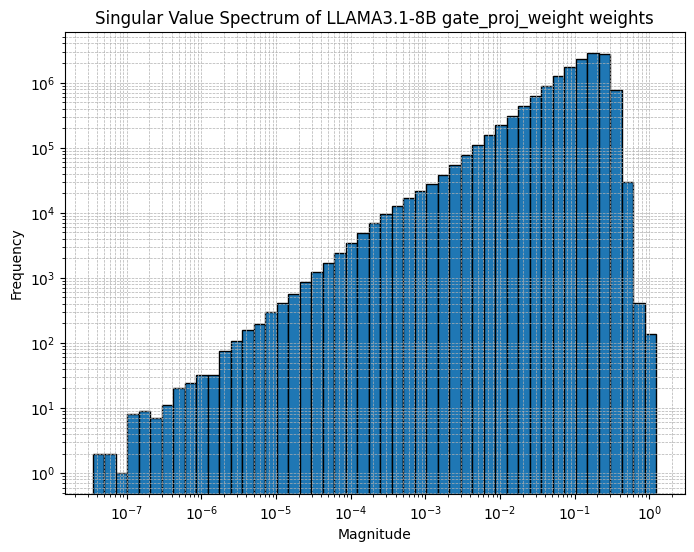

In [18]:
import matplotlib.pyplot as plt
name = "gate_proj_weight"
# Load singular values from all files
singular_values = []
for i in range(1, 33):  # Files from 1 to 32
    filename = f"./data/{name}/singular_values_mlp_{name}_{i}.pt"
    data = torch.load(filename)
    singular_values.extend(data.cpu().numpy().flatten())

# Compute the histogram
singular_values = np.array(singular_values)
bins = np.logspace(np.log10(singular_values.min()), np.log10(singular_values.max()), num=50)
hist, bin_edges = np.histogram(singular_values, bins=bins)

# Plot the spectrum
plt.figure(figsize=(8, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align="edge", edgecolor="k", log=True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title(f"Singular Value Spectrum of LLAMA3.1-8B {name} weights")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.savefig(f"llama3.1-8b_{name}_weight_singular_spectrum.png")
plt.show()

Final K values: [0.         0.05       0.1        0.15000001 0.2        0.25
 0.30000001 0.34999999 0.40000001 0.45000002 0.5        0.55000001
 0.60000002 0.64999998 0.69999999 0.75       0.80000001 0.85000002
 0.89999998 0.94999999]
Final Compression Errors: [99.8125     90.5625     82.375      73.6875     66.6875     59.125
 53.03125    47.28125    41.         35.9375     30.421875   26.015625
 21.890625   17.46875    13.984375   10.296875    7.48828125  5.01171875
  2.59570312  1.00683594]
Final Perplexities: [8.7800006e+05 3.0986331e+05 1.0102091e+05 4.8957880e+04 5.6371190e+04
 1.9571900e+03 1.9385000e+02 6.3190000e+01 2.7230000e+01 1.7960000e+01
 1.3950000e+01 1.2010000e+01 1.0740000e+01 9.5900000e+00 9.1100000e+00
 8.6800000e+00 8.5100000e+00 8.3900000e+00 8.2700000e+00 8.2000000e+00]


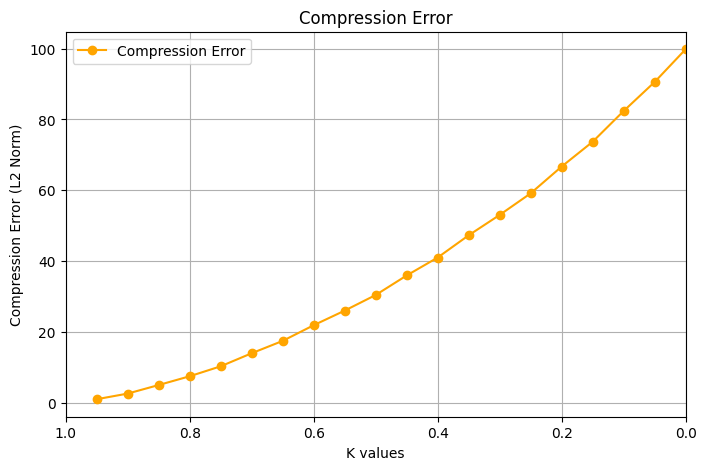

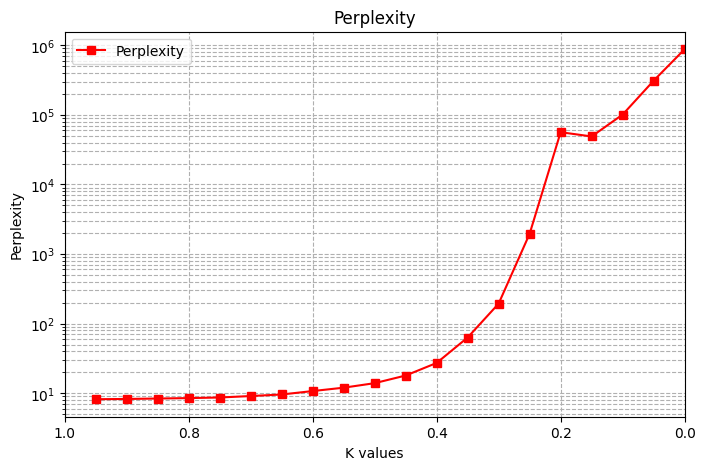

In [7]:

# Re-initialize storage for properly aligned values
k_values_dict = {}
perplexities_dict = {}

current_k = None
current_errors = []

# Re-process log data
# Read log data from file
with open('llama_tile_topk.log', 'r') as f:
    log_data = f.readlines()

for line in log_data:
    # Extract K value
    k_match = re.search(r"topk=([\d\.e-]+)", line)
    if k_match:
        k_value = float(k_match.group(1))
        
        # If switching to a new K, store the previous results
        if current_k is not None and current_errors:
            k_values_dict[current_k] = np.mean(current_errors)
            current_errors = []

        current_k = k_value

    # Extract SVD errors
    error_match = re.search(r"SVD error with topk=[\d\.e-]+ for the down_proj_weight matrix: ([\d\.]+)", line)
    if error_match:
        current_errors.append(float(error_match.group(1)))

    # Extract Perplexity
    perplexity_match = re.search(r"Average perplexity on WikiText-2: ([\d\.]+)", line)
    if perplexity_match and current_k is not None:
        perplexities_dict[current_k] = float(perplexity_match.group(1))

# Store the last K value
if current_k is not None and current_errors:
    k_values_dict[current_k] = np.mean(current_errors)

# Convert to sorted lists
sorted_k_values = sorted(k_values_dict.keys())
compression_errors = [k_values_dict[k] for k in sorted_k_values]
perplexities = [perplexities_dict.get(k, None) for k in sorted_k_values]

# Remove any K values that do not have corresponding perplexities
filtered_k_values = []
filtered_compression_errors = []
filtered_perplexities = []

for k, error, perplexity in zip(sorted_k_values, compression_errors, perplexities):
    if perplexity is not None:
        filtered_k_values.append(k)
        filtered_compression_errors.append(error)
        filtered_perplexities.append(perplexity)

# Convert to numpy arrays
k_values = np.array(filtered_k_values)
compression_errors = np.array(filtered_compression_errors)
perplexities = np.array(filtered_perplexities)

# Debugging: Print extracted values
print("Final K values:", k_values)
print("Final Compression Errors:", compression_errors)
print("Final Perplexities:", perplexities)

# Plot Compression Error
plt.figure(figsize=(8, 5))
plt.plot(k_values, compression_errors, marker='o', linestyle='-', label="Compression Error", color='orange')
plt.xlabel("K values")
plt.ylabel("Compression Error (L2 Norm)")
plt.title("Compression Error")
plt.grid(True)
plt.xlim(1.0, 0.0)  # Ensure K is in descending order
plt.legend()
plt.show()

# Plot Perplexity
plt.figure(figsize=(8, 5))
plt.plot(k_values, perplexities, marker='s', linestyle='-', label="Perplexity", color='red')
plt.xlabel("K values")
plt.ylabel("Perplexity")
plt.yscale("log")  # Log scale to handle large perplexity range
plt.title("Perplexity")
plt.grid(True, which="both", linestyle="--")
plt.xlim(1.0, 0.0)  # Ensure K is in descending order
plt.legend()
plt.show()
